In [35]:
import ujson
import numpy 
import datetime
import json

In [2]:
summaries = {}
ctr = 0
for line in open('user_project_summaries.json'): # lazy iteration because the file is large
#     if ctr == 20: 
#         break
    print ctr,
    ctr+=1
    summaries.update(ujson.loads(line))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46


In [3]:
from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())

In [4]:
# c = 0 
# for userID in summaries: 
#     c += numProjects(getAllProjects(userID))

In [5]:
'''We are using all the data from the user from whom we we have previously 
classfied what their primary langauge is '''

isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
#remove Latin because it's not a reliable inference
#TODO for later: get next-best language besides Latin in the inference function
# remove uncommon languages
lang_counts = {}
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] = lang_counts.get(lang, 0) + 1
    ctr+=1
user_langs = {user: lang for user, lang in user_langs.items() if lang!='la' and lang_counts[lang]>=100 and user in summaries}
langset = sorted(list(set(user_langs.values())))
lang_num_map = {lang: i for i, lang in enumerate(langset)} #key is langauge isocode, value is number 
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages', langset

lang data created with 43862 users and 18 languages [u'ar', u'ca', u'de', u'el', u'en', u'es', u'fr', u'he', u'it', u'ja', u'ko', u'nl', u'pl', u'pt', u'ru', u'th', u'tr', u'zh']


In [6]:
# time utilities
def convert_time(el):
    """Human readable time"""
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

def timediff(t1, t2):
    """difference between times (millisec precision) as days"""
    return (t1-t2)/(86400.*1000)

### Filter Tutorials

In [7]:
not_tutorials = {}

for i in range(10): 
    print i, 
    notT_list = ujson.load(open('tutorial_comparisons/nottutorials_' + str(i) +'.json'))
    for entry in notT_list: 
        if entry[0] not in summaries:
            continue
        proj_name = entry[1].split("_summary.json")[0]
        if entry[0] not in not_tutorials: 
            not_tutorials[entry[0]] = {}
        try: 
            not_tutorials[entry[0]][proj_name] = summaries[entry[0]][proj_name]
        except KeyError: 
            print entry[0], proj_name


0 1 2 3 4 5 6 7 8 9 00999 p005_006_Draw
00999 p002_002_WildLifeShow
00999 p010_010_RememberInformation
00999 p011_011_DetermineLocation
00999 p006_004_Draw2
00999 p012_012_ProcessAList
00999 p008_008_MoleMash


In [8]:
not_tutorials = {user: not_tutorials[user] for user in not_tutorials.keys() if len(not_tutorials[user])>0}
# SR's fix

# Featurizers

## Time featurizer

In [9]:
def projectLengthFeatures(projects):
    """moments of project lengths and intervals, as well as number of projects"""
    lengths = getProjectLengths(projects)
    intervals = getProjectIntervals(projects)
    
    #note: feature names are for our reference only
    userDict = {} 
    userDict["mean of lengths"] = numpy.mean(lengths)
    userDict["stddev of lengths"] = numpy.std(lengths)
    userDict["mean of intervals"] = numpy.mean(lengths)
    userDict["stddev of intervals"] = numpy.std(lengths)
    
    userDict["num projects"] = numProjects(projects)
    
    return userDict

In [10]:
def dayAnalysisFeatures(projects):
    """number of projects on each day of the week, and the percentage of them on a weekday"""
    byday = numOnDay(projects)

    userDict = {day: byday[i] for i, day in enumerate(["Monday", 
                                                       "Tuesday", 
                                                       "Wednesday", 
                                                       "Thursday", 
                                                       "Friday", 
                                                       "Saturday", 
                                                       "Sunday"])}
    return userDict

In [11]:
def decileProjects(projects):
    numbins = 10
    hist = projectsPerUserPeriod(projects, bins=numbins)
    
    userDict = {'decile '+str(i+1): hist[i] for i in range(numbins)}
    return userDict

## Code Features


In [12]:
def deltaDeciles(decileDict, name):
    values = sortDeciles(decileDict)
    deltas = {}
    for i in range(10): 
        if i== 0: pass
        else: deltas[str(i) + " " + name] = values[i]-values[i-1]
    return deltas


def sortDeciles(decileDict):
    deciles_sorted = []
    keys = decileDict.keys()
    for key in keys: 
        deciles_sorted.insert(int(key[-1]), decileDict[key])
    return deciles_sorted



In [13]:
def summaryOBlockDecile(projects): 
    hist = decileOrphanBlocks(projects)
    userDict = {'Orphan Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [14]:
def summaryDecileTLBlocks(projects): 
    hist = decileTypesTopLevelBlocks(projects)
    userDict = {'TopLevel Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [15]:
def summaryDecileNumScreens(projects): 
    hist = decileNumScreens(projects)
    userDict = {'NumScreens Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [16]:
def summaryDeltasTLBlocks(projects): 
    tlblocks = summaryDecileTLBlocks(projects)
    return deltaDeciles(tlblocks, "TL blocks delta")

In [17]:
def summaryDeltasOBlock(projects): 
    oblock = summaryOBlockDecile(projects)
    return deltaDeciles(oblock,"O blocks delta")

In [18]:
def summaryDeltasNumScreens(projects): 
    numscreens = summaryDecileNumScreens(projects)
    return deltaDeciles(numscreens, "numscreens blocks delta")

In [19]:
def summaryAverages(projects):
    userDict = {} 
    userDict["mean of numScreens"] = numpy.mean(getNumScreens(projects))
    userDict["NB"] = averageNumBlocks(projects)
    userDict["OB"] = getAverageOrphanBlocks(projects)
    
    userDict["TL"] = getAverageTypeTLBlocks(projects)
    userDict["TL2"] = getAverageNumTLBlocks(projects)
    
    userDict["NC"] = averageNumComponents(projects)
    userDict["NTC"] = averageNumTypeComponents(projects)

    userDict["MC"] = aveNumMediaAssets(projects)
    
    userDict["NP"] = averageNumProcedures(projects)
    userDict["NS"] = averageNumStrings(projects) 
        
    varList = getAllVariables(projects)
    userDict["local vars"] = varList[0]
    userDict["global vars"] = varList[1]
    
    controls_dict = getControlsBlocks(projects)
    userDict['controls_if'] = controls_dict['controls_if']
    userDict['controls_forEach'] = controls_dict['controls_forEach']
    userDict['controls_choose'] = controls_dict['controls_choose']
    userDict['controls_while'] = controls_dict['controls_while']



    return userDict

In [20]:
def classesFeaturizers(projects): 
    userDict = {} 
    classes = getClasses(projects)
    cList = ['TableArrangement', 'DatePicker', 'Canvas', 
             'CheckBox', 'Web', 'Clock', 'BluetoothServer', 
             'ActivityStarter', 'Texting', 'Label', 'Spinner', 
             'Camera', 'BluetoothClient', 'PhoneCall', 'LocationSensor', 
             'VerticalArrangement', 'HorizontalArrangement', 'Sharing', 
             'TextToSpeech', 'GoogleMap', 'Slider', 'OrientationSensor', 
             'ListView', 'PhoneNumberPicker', 'TinyDB', 'NxtDirectCommands', 
             'Sound', 'ListPicker', 'SpeechRecognizer', 'Button', 'WebViewer',
             'BarcodeScanner', 'NxtDrive', 'Camcorder', 'Notifier', 'TextBox',
             'AccelerometerSensor', 'Image', 'VideoPlayer', 'TinyWebDB',
             'Player', 'File', 'YandexTranslate']
   
    for key in cList: 
        userDict[key] = classes[key]
        
    return userDict

In [21]:
def allBlocksFeaturizer(projects):
    userDict = {}
    with open('all_blocks.json') as data_file:    
        block_list = json.load(data_file)

    all_blocks_dict = {block:0 for block in block_list}
    all_blocks_dict = getBlocks(projects, all_blocks_dict) 
    
    for key in block_list: 
        userDict[key] = all_blocks_dict[key]
    return userDict

In [22]:
# blocks = set() 
# users = summaries.keys()
# c = Counter()

In [23]:
# j = 0
# for userID in users: 
#     i = 0

#     projects = getAllProjects(userID, False)
#     screenNames = getScreenNames(projects)

#     while i < len(projects):
#         for screenName in screenNames[i]:
#                 if screenName in projects[i] and 'Active Blocks' in projects[i][screenName]['Blocks'] and 'Types' in projects[i][screenName]['Blocks']['Active Blocks']:
#                     b = projects[i][screenName]['Blocks']['Active Blocks']['Types']
#                     for block in b: 
#                         if block not in blocks: 
#                             blocks.add(block)
#                     c.update(b)
#         i+=1
#     j+=1 
#     if j % 1000 == 0: 
#         print j,

In [24]:
# with open('top_500_blocks.json', 'w') as data_file:
#     json.dump(dict(c.most_common(500)), data_file)

In [25]:
l = summaries['44884']['p010_009_simplecalc']['Screen1']['Blocks']['Active Blocks']['Types']

In [26]:
# from collections import defaultdict
# from collections import Counter

In [27]:
# c = Counter(l)

NameError: name 'Counter' is not defined

In [ ]:
# i = 0
# for userID in users: 
#     projects = getAllProjects(userID, False)
#     getBlocks(projects, all_blocks_dict)
#     if i %1000 == 0: 
#         print i,
#     i+=1

### Setup

In [28]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [29]:
def getAllProjects(userID, no_tutorials): 
    """list of projects sorted by creation times"""
    if (no_tutorials):
        try: 
            projectlist = not_tutorials[userID].values()
        except:
            print userID
    else: 
        projectlist = summaries[userID].values()
    return sorted(projectlist,
                  key=lambda project: project['**created']) 

def userDuration(projectlist):
    """get the duration (difference between last and earliest creation dates)"""
    return timediff(projectlist[-1]['**created'], projectlist[0]['**created'])


def getProjects(userID, no_tutorials):
    return getAllProjects(userID, no_tutorials)
     

In [30]:
langgroups = {'es': 'eur',
              'pt': 'eur', 
              'it': 'eur', 
              'de': 'eur', 
              'fr': 'eur', 
              'ca': 'eur', 
              'el': 'eur', 
              'nl': 'eur', 
              'pl': 'eur', 
              'ru': 'eur',
              'ko': 'asia', 
              'zh': 'asia', 
              'ja': 'asia', 
              'th': 'asia'}
langgroup_num_map = {'eur': 0, 'asia': 1}



In [31]:
def get_user_labels():
    return {user: lang_num_map[lang] for user, lang in user_langs.items()}

In [32]:
time_combined = combine_featfuncs([projectLengthFeatures, dayAnalysisFeatures,decileProjects])
code_combined = combine_featfuncs([summaryOBlockDecile,summaryDecileTLBlocks,summaryDecileNumScreens,summaryDeltasTLBlocks,summaryDeltasOBlock,summaryDeltasNumScreens, summaryAverages, classesFeaturizers, allBlocksFeaturizer])  

In [36]:
from sklearn.feature_extraction import DictVectorizer

all_features = []
time_features = [] 
code_features = []

userlabels = get_user_labels()

y = []
ctr = 0
for user in userlabels:
    if user in not_tutorials: 

        projects = getProjects(user, True)  # this returns projects sorted by creation date that include tutorials 

        y.append(userlabels[user])

        time_features.append(time_combined(projects))
        code_features.append(code_combined(projects))


        # merge time and code feature dicts
        all_features_user = time_features[-1].copy()
        all_features_user.update(code_features[-1])
        all_features.append(all_features_user)

        ctr+=1
        if ctr%1000==0:
            print ctr/1000,
        


y = numpy.array(y)

timevec = DictVectorizer()

Xtime = timevec.fit_transform(time_features) 

codevec = DictVectorizer()

Xcode = codevec.fit_transform(code_features)

allvec = DictVectorizer()

Xall = allvec.fit_transform(all_features)


/Users/emmalurie/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/emmalurie/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43


In [37]:
from sklearn.preprocessing import scale
from numpy import *
# # convert to dense matrices since these are dense anyway
Xtime = scale(Xtime.toarray())
Xcode = scale(Xcode.toarray())
Xall = scale(Xall.toarray())

/Users/emmalurie/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Chance is 0.478097765171
Building a logreg model with 22 time
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


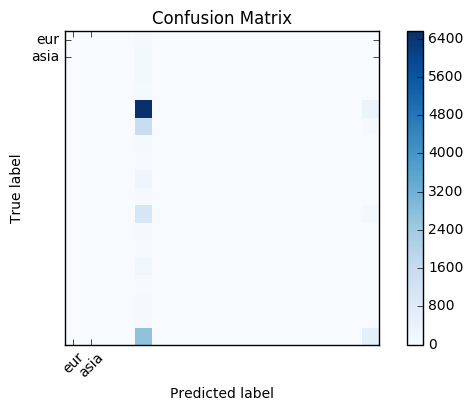

Average accuracy 0.491730616094
Building a logreg model with 1650 code
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


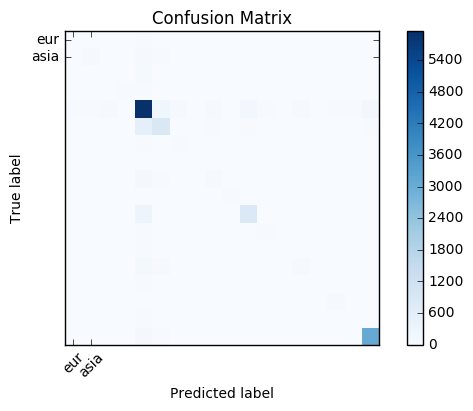

Average accuracy 0.768030056495
Building a logreg model with 1672 all
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


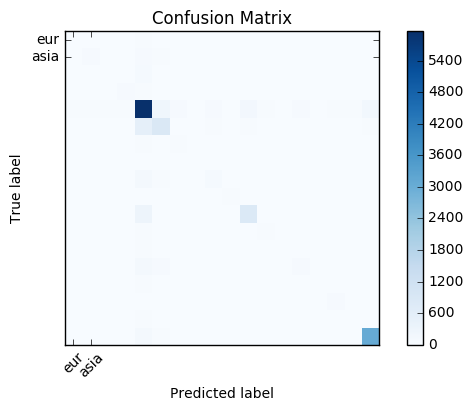

Average accuracy 0.769288186684


In [38]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from plotcnf import plot_confusion_matrix

print 'Chance is', max(numpy.bincount(y))/float(len(y))


foldindices = StratifiedKFold(y)

labels = map(lambda x:x[0], sorted(langgroup_num_map.items(), key=lambda x:x[1]))  
# languages corresponding to class labels as a list

    
k = 70 #num neighbors for kNN

classifiers = [('logreg', LogisticRegression())]  # no knn because it's too slow 
#multi_class='multinomial', 
                                                             

for modelname, model in classifiers:
    for featname, X in [('time', Xtime), ('code', Xcode), ('all', Xall)]:
        print  'Building a', modelname, 'model with', X.shape[1], featname
    
        cvaccs = numpy.zeros(len(foldindices))
        #cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
            model.fit(Xtrain, ytrain)
            cvaccs[i] = model.score(Xtest, ytest)
        
            predictions = model.predict(Xtest)
            #cvf1[i] = f1_score(ytest, predictions)
            
            #print '****', modelname, cvaccs[i]
        #analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plot_confusion_matrix(cnf_matrix, labels)
        plt.show()
        
        print 'Average accuracy', numpy.mean(cvaccs)